In [671]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from catboost import CatBoostRegressor

from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [515]:
df = pd.read_csv('train.csv')
X = df.drop(['Id', 'Price'], axis = 1)
y = df.Price

In [516]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [517]:
X.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


In [418]:
def check_missing(data, output_path=None):
    """Считаем количество пропусков и долю пропусков."""
    result = pd.concat([data.isnull().sum(), data.isnull().mean()], axis=1)
    result = result.rename(index=str, columns={0: 'total missing', 1: 'proportion'})
    if output_path:
        result.to_csv(f'{output_path}missing.csv')
        print(output_path, 'missing.csv')
    return result

In [518]:
check_missing(X)

,total missing,proportion
DistrictId,0,0.0000
Rooms,0,0.0000
Square,0,0.0000
LifeSquare,2113,0.2113
KitchenSquare,0,0.0000
Floor,0,0.0000
HouseFloor,0,0.0000
HouseYear,0,0.0000
Ecology_1,0,0.0000
Ecology_2,0,0.0000


Присутствуют пропуски по LifeSquare и Healthcare_1. Заполним их

In [420]:
def impute_NA_with_avg(data,strategy='mean', NA_col=None):
    """Заполняет пропущенные значения в ``NA_col`` по стратегии ``strategy``."""
    NA_col = NA_col or []
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum() > 0:
            if strategy=='mean':
                data_copy[f"{i}_impute_mean"] = data_copy[i].fillna(data[i].mean())
            elif strategy=='median':
                data_copy[f'{i}_impute_median'] = data_copy[i].fillna(data[i].median())
            elif strategy=='mode':
                data_copy[f'{i}_impute_mode'] = data_copy[i].fillna(data[i].mode()[0])
        else:
            warn("Нет пропущенных значений" % i)
    return data_copy  

In [519]:
X = impute_NA_with_avg(data=X,NA_col=['LifeSquare', 'Healthcare_1']) 
X.head(8)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_impute_mean,Healthcare_1_impute_mean
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,29.442751,1142.90446
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,40.049543,240.00000
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,29.197612,229.00000
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,52.731512,1084.00000
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,23.776169,2078.00000
5,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,46.683720,990.00000
6,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,37.160377,1142.90446
7,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,37.199645,1142.90446


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CE4122E988>,
      dtype=object)

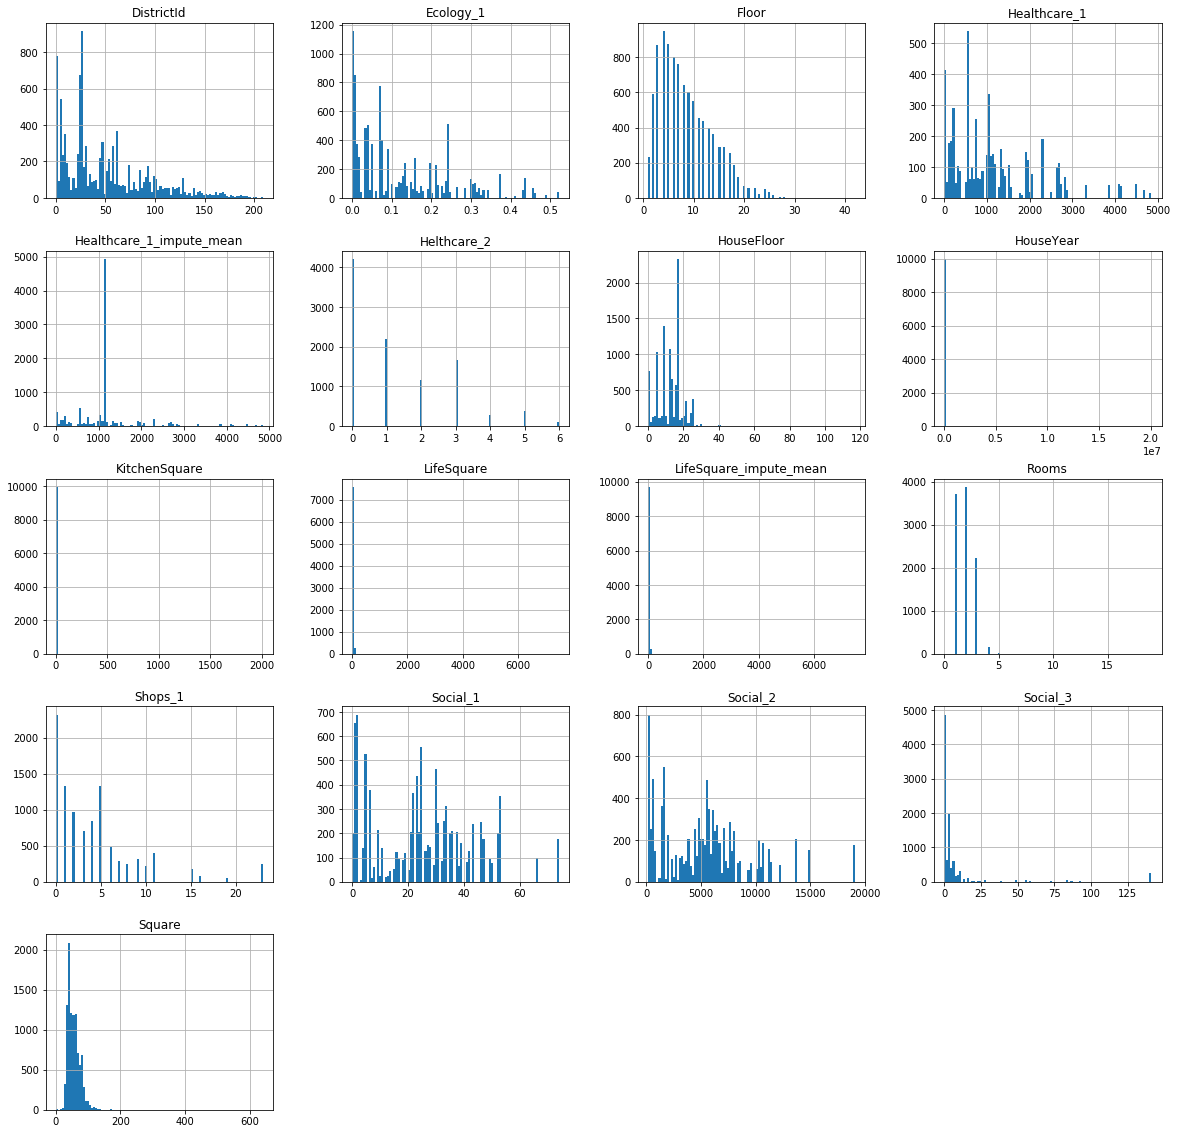

In [520]:
X.hist(bins = 100, figsize = (20, 20))

Присутствуют нулевые значения по фичам Rooms, Square, KitchenSquare и HouseFloor. Заполним их значениями и избавимся от выбросов

In [521]:
def windsorization(data, col, params, strategy='both'):
    """Заменяем все значения большие params[1] значением params[1], а значения меньше params[0] значением params[0].
    При ``strategy = both`` - заменяем снизу и сверху,
        ``strategy = top`` - заменяем только сверху,
        ``strategy = bottom`` - заменяем только снизу."""
    data_copy = data.copy(deep=True)  
    if strategy == 'both':
        data_copy.loc[data_copy[col] > params[0], col] = params[0]
        data_copy.loc[data_copy[col] < params[1], col] = params[1]
    elif strategy == 'top':
        data_copy.loc[data_copy[col] > params[0], col] = params[0]
    elif strategy == 'bottom':
        data_copy.loc[data_copy[col] < params[1], col] = params[1]  
    return data_copy

In [522]:
X['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [523]:
params = [6, 1]
X = windsorization(data=X, col='Rooms', params=params, strategy='both')

In [524]:
X['Rooms'].value_counts()

2.0    3880
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       4
Name: Rooms, dtype: int64

In [525]:
params = [250, 20]
X = windsorization(data=X, col='Square', params=params, strategy='both')

In [526]:
params = [20, 3]
X = windsorization(data=X, col='KitchenSquare', params=params, strategy='both')

In [527]:
params = [30, 1]
X = windsorization(data=X, col='HouseFloor', params=params, strategy='both')

In [528]:
params = [230, 18]
X = windsorization(data=X, col='LifeSquare', params=params, strategy='both')

In [529]:
params = [2020, 1910]
X = windsorization(data=X, col='HouseYear', params=params, strategy='both')

In [530]:
X.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,LifeSquare_impute_mean,Healthcare_1_impute_mean
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.889200,56.244667,36.601653,6.444400,8.526700,12.591700,1984.872400,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,37.199645,1142.904460
std,43.587592,0.815592,19.364709,17.885555,3.168614,5.241148,6.461267,18.416347,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,76.588742,736.734238
min,0.000000,1.000000,20.000000,18.000000,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.370619,0.000000
25%,20.000000,1.000000,41.774881,22.769832,3.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,25.527399,830.000000
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,37.199645,1142.904460
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,41.427234,1142.904460
max,209.000000,6.000000,250.000000,230.000000,20.000000,42.000000,30.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,7480.592129,4849.000000


In [531]:
X[X['LifeSquare'] > X['Square']].head(8)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_impute_mean,Healthcare_1_impute_mean
28,23,1.0,42.530043,43.967759,3.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,43.967759,1142.90446
44,38,3.0,104.211396,106.340403,3.0,20,1.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,106.340403,520.00000
52,1,2.0,61.400054,65.224603,3.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,65.224603,1142.90446
123,25,3.0,85.952306,89.803753,3.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,89.803753,1142.90446
153,62,1.0,51.831473,53.491301,3.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,53.491301,1142.90446
178,57,1.0,29.298168,29.770784,5.0,7,5.0,1964,0.133215,B,B,49,11395,3,1406.0,3,4,A,29.770784,1406.00000
184,74,1.0,48.743665,51.011232,3.0,12,20.0,2017,0.075779,B,B,6,1437,3,NaN,0,2,B,51.011232,1142.90446
212,88,2.0,20.000000,67.628717,3.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,67.628717,1142.90446


In [532]:
square = X[X['LifeSquare'] > X['Square']]['Square']

In [533]:
kitchensquare = X[X['LifeSquare'] > X['Square']]['KitchenSquare']

In [534]:
X.loc[:,'LifeSquare'] = square - kitchensquare

In [535]:
X[X['LifeSquare'] > X['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_impute_mean,Healthcare_1_impute_mean


In [536]:
X[X['Floor'] > X['HouseFloor']].head(8)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_impute_mean,Healthcare_1_impute_mean
7,74,2.0,80.312926,NaN,3.0,14,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,37.199645,1142.90446
14,27,1.0,53.769097,NaN,3.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,52.408027,1142.90446
16,27,2.0,49.360648,NaN,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,NaN,0,0,B,31.993964,1142.90446
21,27,2.0,64.711835,NaN,3.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,37.199645,1142.90446
23,54,3.0,118.907612,NaN,3.0,2,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,37.199645,645.00000
26,27,3.0,106.958871,NaN,3.0,17,1.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,0.641822,1142.90446
35,200,3.0,85.280389,NaN,9.0,6,5.0,1960,0.000000,B,B,33,7425,1,NaN,2,5,B,58.447967,1142.90446
39,23,2.0,60.503248,NaN,3.0,16,1.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,37.199645,1142.90446


In [537]:
X= pd.get_dummies(X)
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Helthcare_2,Shops_1,LifeSquare_impute_mean,Healthcare_1_impute_mean,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,35,2.0,47.981561,NaN,6.0,7,9.0,1969,0.089040,33,...,0,11,29.442751,1142.90446,0,1,0,1,0,1
1,41,3.0,65.683640,NaN,8.0,7,9.0,1978,0.000070,46,...,1,16,40.049543,240.00000,0,1,0,1,0,1
2,53,2.0,44.947953,NaN,3.0,8,12.0,1968,0.049637,34,...,1,3,29.197612,229.00000,0,1,0,1,0,1
3,58,2.0,53.352981,NaN,9.0,8,17.0,1977,0.437885,23,...,0,5,52.731512,1084.00000,0,1,0,1,0,1
4,99,1.0,39.649192,NaN,7.0,11,12.0,1976,0.012339,35,...,2,4,23.776169,2078.00000,0,1,0,1,0,1


In [538]:
feature_names = ['Rooms', 'Square', 'LifeSquare_impute_mean', 'KitchenSquare', 'Floor',
                    'HouseFloor', 'HouseYear', 'Helthcare_2', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                    'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
                    'Healthcare_1_impute_mean']
target_name = 'Price'

In [539]:
X = X[feature_names]

In [546]:
model = RandomForestRegressor(n_estimators=1000, max_depth=16, random_state=42, max_features=7)
model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [550]:
from sklearn.metrics import r2_score

In [552]:
y_pred = model.predict(X)

In [553]:
r2_score(y, y_pred)

0.9390814629743024

In [651]:
X_final = pd.read_csv('test.csv')
preds_final['Id'] = X_final['Id'].copy()
X_final

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [652]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [653]:
X_final = impute_NA_with_avg(data=X_final,NA_col=['LifeSquare', 'Healthcare_1']) 

In [654]:
params = [6, 1]
X_final = windsorization(data=X_final, col='Rooms', params=params, strategy='both')

In [655]:
params = [250, 20]
X_final = windsorization(data=X_final, col='Square', params=params, strategy='both')

In [656]:
params = [20, 3]
X_final = windsorization(data=X_final, col='KitchenSquare', params=params, strategy='both')

In [657]:
params = [30, 1]
X_final = windsorization(data=X_final, col='HouseFloor', params=params, strategy='both')

In [658]:
params = [230, 18]
X_final = windsorization(data=X_final, col='LifeSquare', params=params, strategy='both')

In [659]:
params = [2020, 1910]
X_final = windsorization(data=X_final, col='HouseYear', params=params, strategy='both')

In [660]:
square = X_final[X_final['LifeSquare'] > X_final['Square']]['Square']
kitchensquare = X_final[X_final['LifeSquare'] > X_final['Square']]['KitchenSquare']
X_final.loc[:,'LifeSquare'] = square - kitchensquare

In [661]:
X_final = pd.get_dummies(X_final)

In [662]:
X_final = X_final[feature_names]

In [663]:
y_pred_final = model.predict(X_final)

In [664]:
len(y_pred_final)


5000

In [665]:
len(X_final)

5000

In [603]:
pd.concat([preds_final, pd.DataFrame(y_pred_final)], axis=1).to_csv('./predictions.csv', index=False, encoding='utf-8', sep=',')

In [666]:
final = pd.concat([preds_final, pd.DataFrame(y_pred_final)], axis=1)

In [668]:
final = final.set_axis(['Id','Price'], axis=1, inplace=False)

In [670]:
final.to_csv('./predictions.csv', index=False, encoding='utf-8', sep=',')

In [673]:
parameters = {'silent': True, 
              'learning_rate': 0.023, 
              'iterations': 1005, 
              'eval_metric': 'R2', 
              'depth': 10,
              'allow_writing_files': False}


model_CBR = CatBoostRegressor(**parameters)

model_CBR.fit(X, y)

In [674]:
y_pred_final = model_CBR.predict(X_final)

In [675]:
final = pd.concat([preds_final, pd.DataFrame(y_pred_final)], axis=1)
final = final.set_axis(['Id','Price'], axis=1, inplace=False)
final.to_csv('./predictions.csv', index=False, encoding='utf-8', sep=',')